In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from itertools import product
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/23", start_date=date(2022, 9, 5), end_date=date(2023, 1, 29)
    ),
    SeasonRange(
        season="2023/24", start_date=date(2023, 9, 4), end_date=date(2024, 1, 28)
    ),
    SeasonRange(
        season="2024/25", start_date=date(2024, 9, 2), end_date=date(2025, 1, 26)
    ),
]
date_ranges = daily_date_ranges(season_ranges)

In [5]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age", categories=("adult", "senior", "elderly")
)

In [6]:
params = []

params_grid = {
    "2022/23": {
        "m": -0.75,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.05,
        },
        "senior": {
            "m": 1.0,
        },
        "elderly": {
            "m": 1.8,
        },
    },
    "2023/24": {
        "m": -0.725,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.06,
        },
        "senior": {
            "m": 1.05,
        },
        "elderly": {
            "m": 1.75,
        },
    },
    "2024/25": {
        "m": -0.78,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.04,
        },
        "senior": {
            "m": 1.1,
        },
        "elderly": {
            "m": 1.85,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    )
                )

pprint(params)

[('m', '2022/23', 'female', 'adult', -0.75),
 ('m', '2022/23', 'female', 'senior', 0.25),
 ('m', '2022/23', 'female', 'elderly', 1.05),
 ('m', '2022/23', 'male', 'adult', -0.8),
 ('m', '2022/23', 'male', 'senior', 0.19999999999999996),
 ('m', '2022/23', 'male', 'elderly', 1.0),
 ('m', '2023/24', 'female', 'adult', -0.725),
 ('m', '2023/24', 'female', 'senior', 0.32500000000000007),
 ('m', '2023/24', 'female', 'elderly', 1.025),
 ('m', '2023/24', 'male', 'adult', -0.7849999999999999),
 ('m', '2023/24', 'male', 'senior', 0.2650000000000001),
 ('m', '2023/24', 'male', 'elderly', 0.9650000000000001),
 ('m', '2024/25', 'female', 'adult', -0.78),
 ('m', '2024/25', 'female', 'senior', 0.32000000000000006),
 ('m', '2024/25', 'female', 'elderly', 1.07),
 ('m', '2024/25', 'male', 'adult', -0.8200000000000001),
 ('m', '2024/25', 'male', 'senior', 0.28),
 ('m', '2024/25', 'male', 'elderly', 1.03),
 ('r', '2022/23', 'female', 'adult', -3.2),
 ('r', '2022/23', 'female', 'senior', -3.2),
 ('r', '2022

In [7]:
observations = sample_dataset(
    logistic_curve, season_ranges, date_ranges, [sex_cov, age_cov], params, 0.0005
)
observations

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,adult,incidence,1.945748e-03
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,senior,incidence,3.322552e-03
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,elderly,incidence,4.640228e-03
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,male,adult,incidence,1.455564e-03
4,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,male,senior,incidence,3.269788e-03
...,...,...,...,...,...,...,...,...,...,...
2641,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,female,senior,incidence,7.147171e-04
2642,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,female,elderly,incidence,2.935718e-04
2643,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,male,adult,incidence,4.125017e-07
2644,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,male,senior,incidence,3.008790e-04


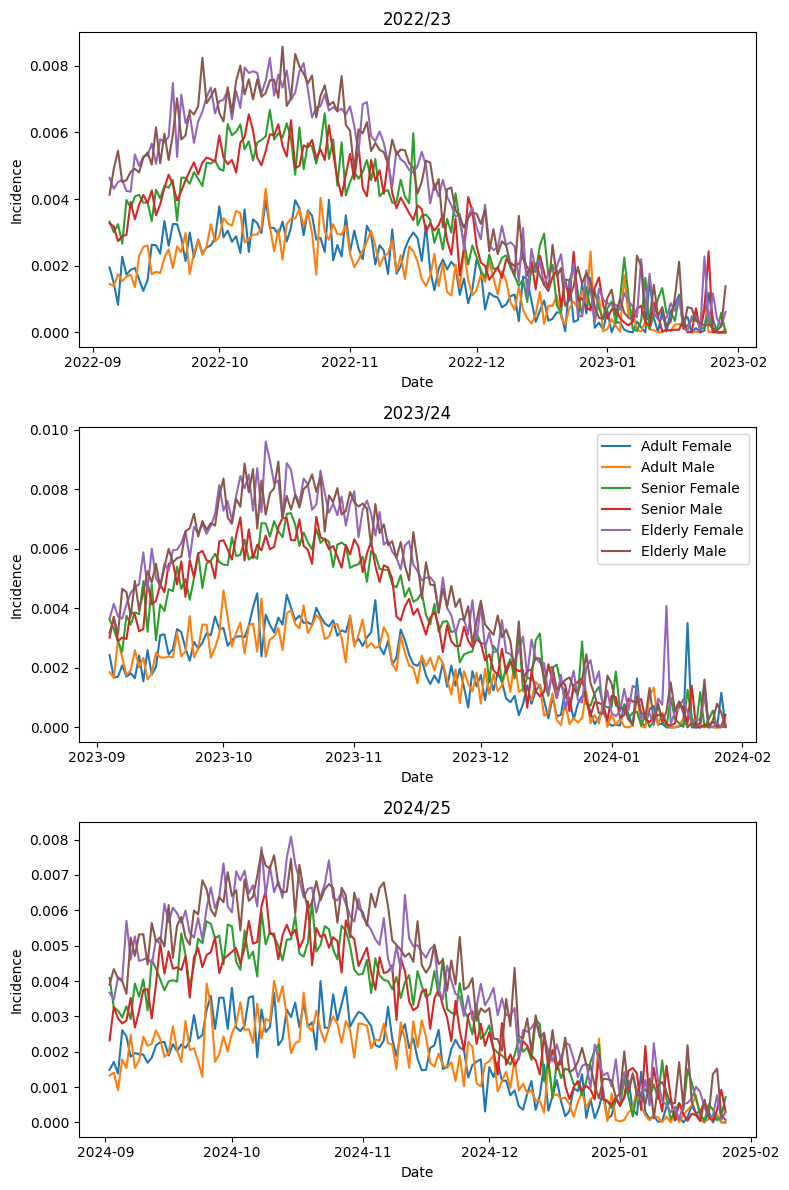

In [8]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [9]:
observations_prevalence = observations.copy()
observations_prevalence = observations_prevalence.sort_values(
    [
        "start_date",
        "end_date",
        "season",
        "season_start_date",
        "season_end_date",
        "sex",
        "age",
    ]
)
observations_prevalence["prevalence"] = (
    observations_prevalence.groupby(["season", "sex", "age"])["value"]
    .cumsum()
    .reset_index()["value"]
)
observations_prevalence

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value,prevalence
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,adult,incidence,1.945748e-03,0.001946
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,elderly,incidence,4.640228e-03,0.003323
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,female,senior,incidence,3.322552e-03,0.004640
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,male,adult,incidence,1.455564e-03,0.001456
5,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-05,2022-09-05,male,elderly,incidence,4.131079e-03,0.003270
...,...,...,...,...,...,...,...,...,...,...,...
2642,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,female,elderly,incidence,2.935718e-04,0.456885
2641,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,female,senior,incidence,7.147171e-04,0.584390
2643,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,male,adult,incidence,4.125017e-07,0.240376
2645,2024/25,2024-09-02,2025-01-26,2025-01-26,2025-01-26,2025-01-26,male,elderly,incidence,7.153752e-05,0.445538


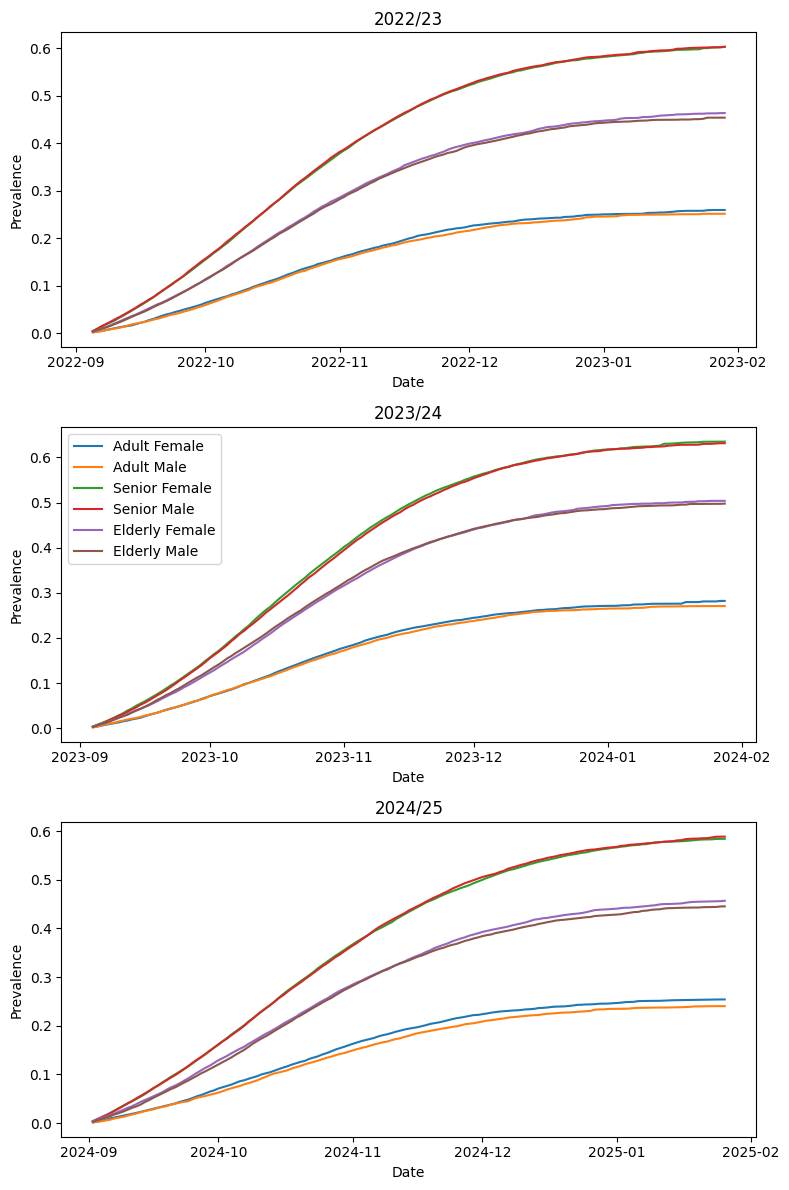

In [10]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [11]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -0.75, "sigma": 0.05},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.1},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 5.0},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[1.0, 1.8],
            mu=2 * [0.0],
            sigma=2 * [0.05],
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=-0.05,
            mu=0.0,
            sigma=0.01,
        ),
    ],
    observations=observations,
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.001,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=5e-5,
    pooled_epsilon=True,
)
model

In [12]:
model.build(debug=True)

INFO: Using 441 date ranges for the uptake model.
INFO: Using 2646 observational date ranges for the uptake model.
INFO: Added season 2022/23 to the model with 147 days.
INFO: Added season 2023/24 to the model with 147 days.
INFO: Added season 2024/25 to the model with 147 days.
INFO: Added covariate MSeason to the model with shape [3].
INFO: Added covariate RSeason to the model with shape [3].
INFO: Added covariate SSeason to the model with shape [3].
INFO: Added covariate MAge to the model with shape [3 2].
INFO: Added covariate MSex to the model with shape [3].
INFO: Added summed parameter MSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202223SexFemaleAgeAdult to the model.
INFO: Added summed parameter MSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter RSeason202324SexFemaleAgeAdult to the model.
INFO: Added summed parameter SSeason202324SexFemaleAgeAdult

In [13]:
model.sample(
    tune=2000,
    draws=1000,
    chains=4,
)

Running window adaptation


There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


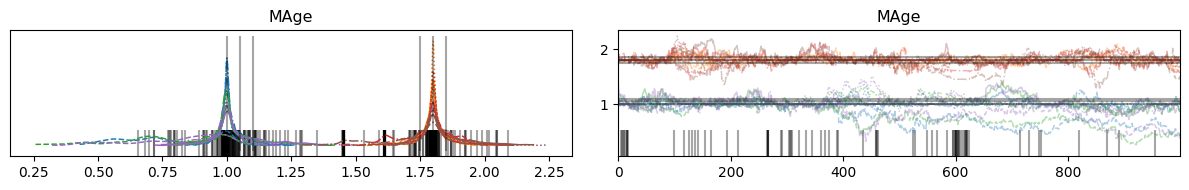

In [ ]:
az.plot_trace(
    model._trace,
    var_names=["MAge"],
    lines=[
        (
            "MAge",
            {},
            [
                1.0,  # Senior, 2022/23
                1.05,  # Senior, 2023/24
                1.1,  # Senior, 2024/25
                1.8,  # Elderly, 2022/23
                1.75,  # Elderly, 2023/24
                1.85,  # Elderly, 2024/25
            ],
        ),
    ],
    compact=True,
)
plt.tight_layout()

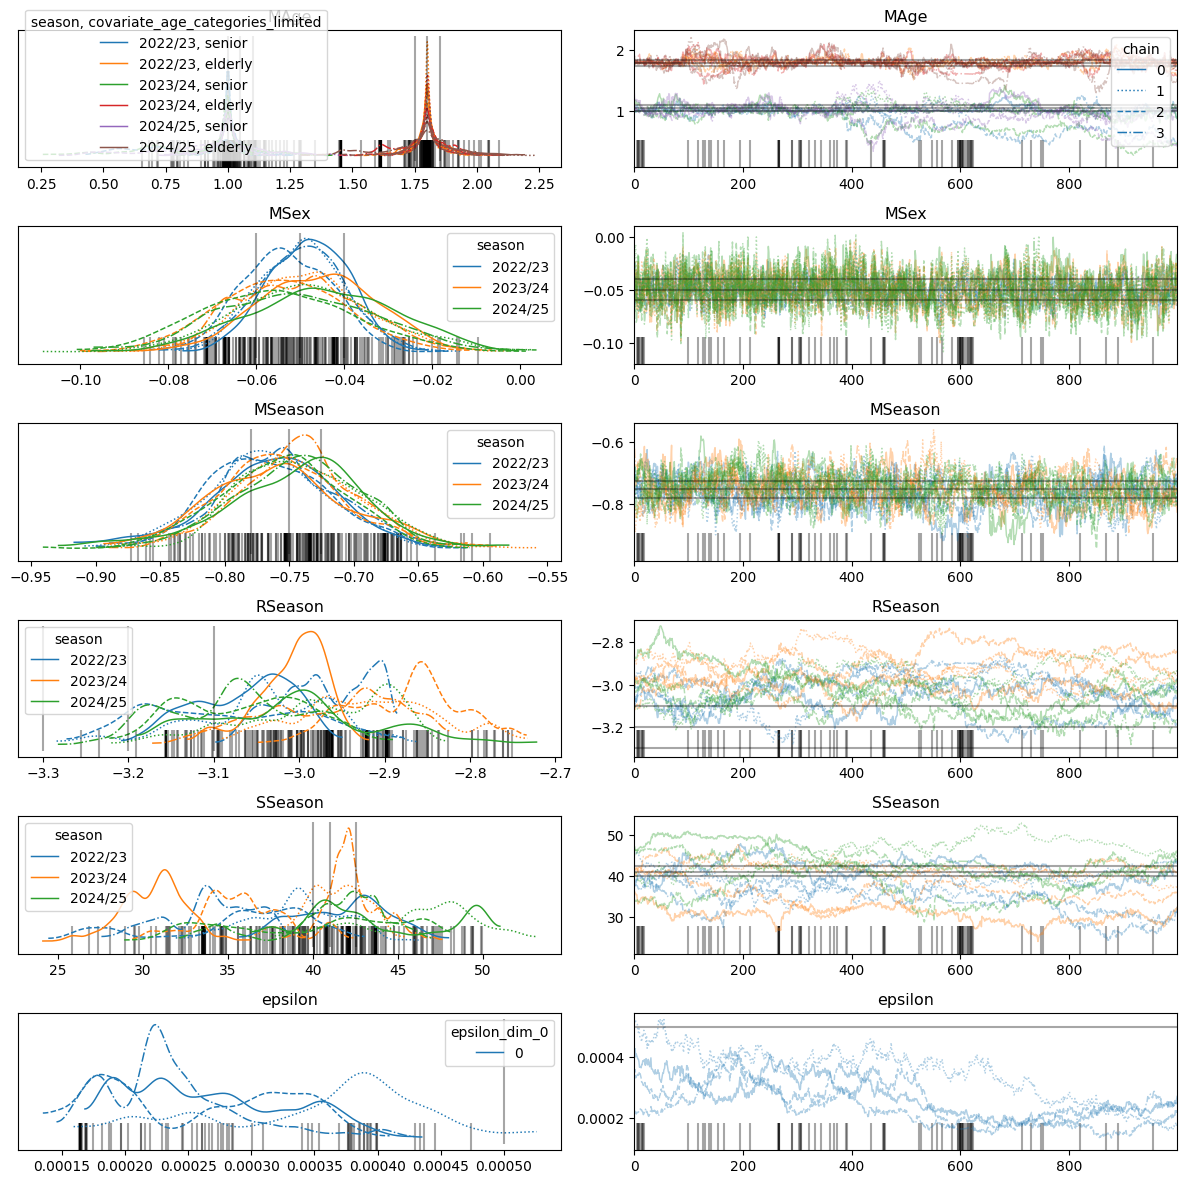

In [14]:
az.plot_trace(
    model._trace,
    var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"],
    lines=[
        ("MAge", {}, [1.0, 1.8, 1.05, 1.75, 1.1, 1.85]),
        ("MSex", {}, [-0.05, -0.06, -0.04]),
        ("MSeason", {}, [-0.75, -0.725, -0.78]),
        ("RSeason", {}, [-3.2, -3.1, -3.3]),
        ("SSeason", {}, [40.0, 42.5, 41.0]),
        ("epsilon", {}, [0.0005]),
    ],
    legend=True,
    compact=True,
)
plt.tight_layout()

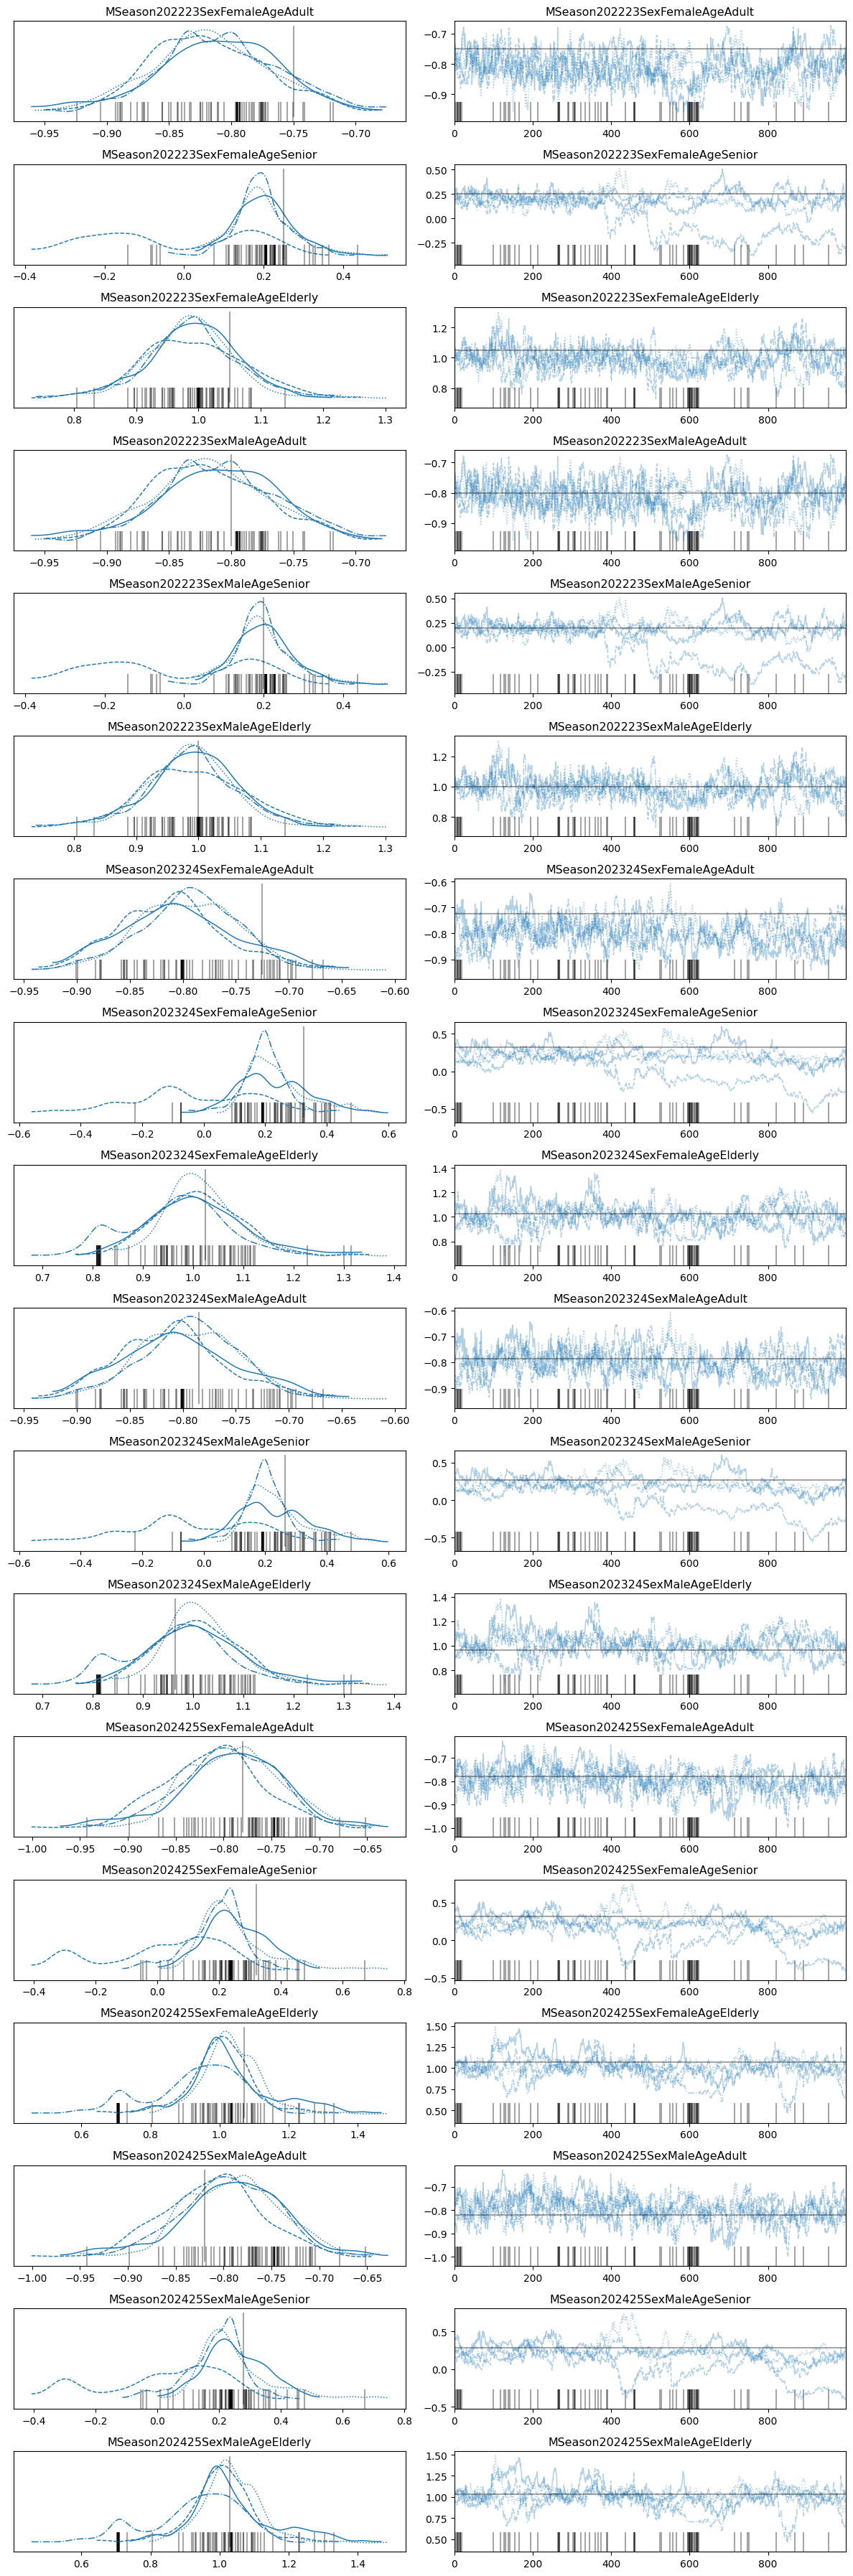

In [15]:
var_names_and_lines = {
    (
        f"{p[0].title()}Season{p[1].replace('/', '').title()}"
        f"Sex{p[2].title()}Age{p[3].title()}"
    ): p[4]
    for p in params
    if p[0] == "m"
}

az.plot_trace(
    model._trace,
    var_names=list(var_names_and_lines.keys()),
    lines=[(k, {}, v) for k, v in var_names_and_lines.items()],
)
plt.tight_layout()

In [16]:
incidence_posterior_df = model.dataframe()
incidence_posterior_df.head(10)

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/23,2022-09-05,female,adult,incidence,0.001459
1,0,0,2022/23,2022-09-06,female,adult,incidence,0.001206
2,0,0,2022/23,2022-09-07,female,adult,incidence,0.002020
3,0,0,2022/23,2022-09-08,female,adult,incidence,0.001872
4,0,0,2022/23,2022-09-09,female,adult,incidence,0.001902
5,0,0,2022/23,2022-09-10,female,adult,incidence,0.001775
6,0,0,2022/23,2022-09-11,female,adult,incidence,0.001482
7,0,0,2022/23,2022-09-12,female,adult,incidence,0.001847
8,0,0,2022/23,2022-09-13,female,adult,incidence,0.001713
9,0,0,2022/23,2022-09-14,female,adult,incidence,0.002920


In [17]:
incidence_posterior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10584000 entries, 0 to 587999
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   draw    int64         
 1   chain   int64         
 2   season  string        
 3   date    datetime64[ns]
 4   sex     string        
 5   age     string        
 6   type    string        
 7   value   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 726.7 MB


In [18]:
incidence_posterior_df[
    (incidence_posterior_df["draw"] == 0) & (incidence_posterior_df["chain"] == 0)
]

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/23,2022-09-05,female,adult,incidence,1.458621e-03
1,0,0,2022/23,2022-09-06,female,adult,incidence,1.205887e-03
2,0,0,2022/23,2022-09-07,female,adult,incidence,2.020461e-03
3,0,0,2022/23,2022-09-08,female,adult,incidence,1.872175e-03
4,0,0,2022/23,2022-09-09,female,adult,incidence,1.902280e-03
...,...,...,...,...,...,...,...,...
142,0,0,2024/25,2025-01-22,male,elderly,incidence,1.437936e-04
143,0,0,2024/25,2025-01-23,male,elderly,incidence,1.961565e-10
144,0,0,2024/25,2025-01-24,male,elderly,incidence,8.694904e-07
145,0,0,2024/25,2025-01-25,male,elderly,incidence,3.850617e-05


In [19]:
summary_posterior_df = (
    incidence_posterior_df.groupby(
        # ["chain", "draw", "season", pd.Grouper(key="date", freq="W"), "sex", "age"]
        ["chain", "draw", "season", "date", "sex", "age"]
    )["value"]
    .sum()
    .reset_index()
)
summary_posterior_df = summary_posterior_df.rename(columns={"date": "end_date"})
# summary_posterior_df["start_date"] = summary_posterior_df["end_date"] - pd.Timedelta(
#     days=6
# )
summary_posterior_df["start_date"] = summary_posterior_df["end_date"]
summary_posterior_df = (
    summary_posterior_df.groupby(["season", "start_date", "end_date", "sex", "age"])[
        "value"
    ]
    .agg(
        [
            lambda x: np.quantile(x, 0.025),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.975),
        ]
    )
    .reset_index()
)
summary_posterior_df = summary_posterior_df.rename(
    columns={
        summary_posterior_df.columns[-3]: "lower",
        summary_posterior_df.columns[-2]: "median",
        summary_posterior_df.columns[-1]: "upper",
    }
)
summary_posterior_df

,season,start_date,end_date,sex,age,lower,median,upper
0,2022/23,2022-09-05,2022-09-05,female,adult,1.075221e-03,0.001807,0.002633
1,2022/23,2022-09-05,2022-09-05,female,elderly,3.066932e-03,0.004277,0.005915
2,2022/23,2022-09-05,2022-09-05,female,senior,2.208472e-03,0.003122,0.004312
3,2022/23,2022-09-05,2022-09-05,male,adult,1.054479e-03,0.001796,0.002617
4,2022/23,2022-09-05,2022-09-05,male,elderly,3.066232e-03,0.004285,0.005896
...,...,...,...,...,...,...,...,...
2641,2024/25,2025-01-26,2025-01-26,female,elderly,1.116372e-08,0.000151,0.001031
2642,2024/25,2025-01-26,2025-01-26,female,senior,2.789237e-11,0.000080,0.000956
2643,2024/25,2025-01-26,2025-01-26,male,adult,2.809511e-30,0.000004,0.000785
2644,2024/25,2025-01-26,2025-01-26,male,elderly,1.868712e-08,0.000144,0.000978


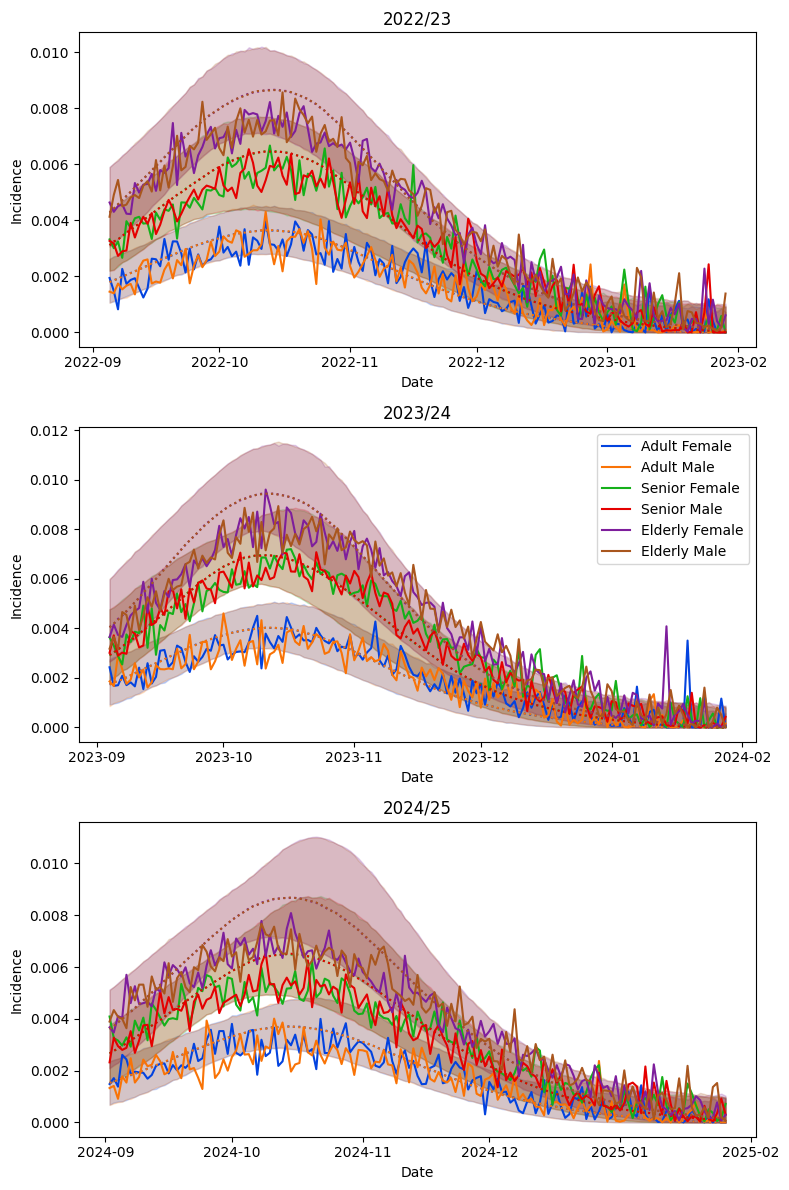

In [20]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = summary_posterior_df[
                (summary_posterior_df["season"] == season_range.season)
                & (summary_posterior_df["age"] == age_category)
                & (summary_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()